In [46]:
import os, torch, torch.nn as nn, torchvision, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import PIL.Image as Image
import re
import numpy as np
import torchvision.transforms.v2 as transforms
from torchvision import datapoints
from torchvision.models import ResNet50_Weights
from torchvision.models import resnet50
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_bounding_boxes


train_folder = 'images/images/'

In [47]:
import xml.etree.ElementTree as ET
import pandas as pd

xmls_folder = 'annotations/annotations/xmls/'
xmls_filenames=[]
for filename in os.listdir(xmls_folder):
    xmls_filenames.append(filename)

# remove all files that are not xmls
for filename in xmls_filenames:
    if not filename.endswith('.xml'):
        xmls_filenames.remove(filename)

# read xmls and collect in dataframe
df=pd.DataFrame(columns=['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'])
for filename in tqdm(xmls_filenames):
    tree = ET.parse(xmls_folder+filename)
    root = tree.getroot()
    height = int(root.find("size")[0].text)
    width = int(root.find("size")[1].text)
    channels = int(root.find("size")[2].text)
    jpgname=root.find("filename").text
    for member in root.findall("object"):
        bndbox = member.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        label = re.split('_', jpgname)
        if len(label) == 2:
            label = label[0]
        else:
            label = label[0]+"_"+label[1]
        df.loc[len(df)] = [jpgname, width, height, label, xmin, ymin, xmax, ymax]
# use column filename as index
df.set_index('filename', inplace=True)

  0%|          | 0/3686 [00:00<?, ?it/s]

In [48]:
df

,width,height,class,xmin,ymin,xmax,ymax
filename,,,,,,,
British_Shorthair_10.jpg,350,233,British_Shorthair,83,29,197,142
german_shorthaired_119.jpg,500,500,german_shorthaired,128,22,240,222
english_setter_158.jpg,500,333,english_setter,97,35,304,199
Siamese_178.jpg,400,500,Siamese,32,18,363,369
pomeranian_162.jpg,300,222,pomeranian,19,32,123,129
...,...,...,...,...,...,...,...
english_setter_155.jpg,390,500,english_setter,312,80,465,260
Birman_181.jpg,333,500,Birman,153,14,416,257
newfoundland_112.jpg,500,489,newfoundland,50,75,410,440


nicht jedes Bild ist annotiert, daher nur training mit den annotierten Bildern


In [91]:
def get_bbox_part(filename, part):
    # convert to float
    return df.loc[filename, part]

# dict to convert label to label_idx
classes=df['class'].unique()
classes_idx={}
for i, c in enumerate(classes):
    classes_idx[c]=i

def convert_tensor_to_image(tensor_image, bbox):
    # convert tensor to image

    # draw bounding box
    image=draw_bounding_boxes(image, bbox)
    return image


TypeError: Tensor expected, got <class 'PIL.Image.Image'>

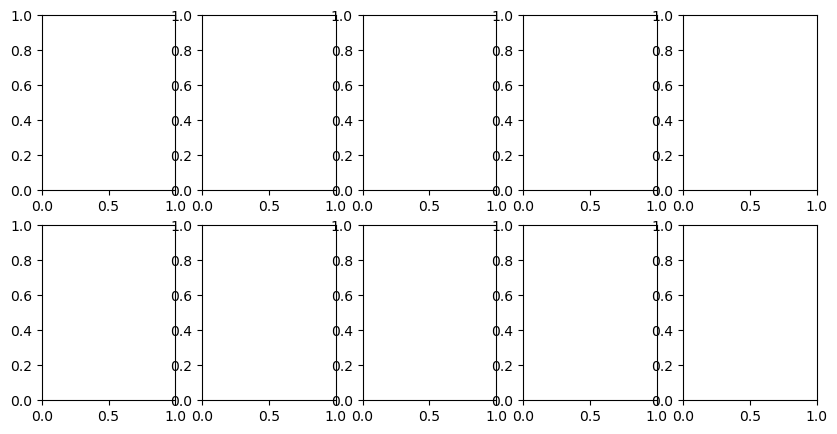

In [92]:
class PetDataset(Dataset):
    def __init__(self, filenames, labels, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname=self.filenames[idx]
        image = Image.open(train_folder+fname)
        image = image.convert('RGB')
        label = classes_idx[self.labels[idx]]
        bbox=datapoints.BoundingBox([[get_bbox_part(fname, 'xmin'),
                                    get_bbox_part(fname, 'ymin'),
                                    get_bbox_part(self.filenames[idx], 'xmax'),
                                    get_bbox_part(self.filenames[idx], 'ymax')]],
                                    format=datapoints.BoundingBoxFormat.XYXY,
                                    spatial_size=F.get_spatial_size(image))
        if self.transform:
            image, bbox = self.transform(image, bbox)
        return image, label, bbox


transform=transforms.Compose([
    transforms.ToImageTensor(),
    # to float
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((300, 300), antialias=True),
    # horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),
    # jitter brightness, contrast and saturation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # randomly crop image
    transforms.RandomCrop(224, pad_if_needed=True, padding_mode='reflect'),
    # warp
    transforms.RandomPerspective(distortion_scale=0.3, p=0.6),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


sample_dataset=PetDataset(df.iloc[:20].index, df.iloc[:20]["class"], transform=transform)
sample_dataloader=DataLoader(sample_dataset, batch_size=10, shuffle=True)

# visualize a batch of images using the dataloader
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
index=0
for xb, yb, bbox in sample_dataloader:
    for row in range(2):
        for col in range(5):
            image=convert_tensor_to_image(xb[row*5+col], bbox[row*5+col])
            ax[row, col].imshow(image.permute(1, 2, 0))
            ax[row, col].set_title(classes[yb[row*5+col].item()])
            ax[row, col].axis('off')

In [ ]:
%debug

In [45]:
X_train, X_test, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42, shuffle=True)

In [18]:


# use a pretrained resnte50

class OxfordPetsModel(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.resnet50=resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet50.fc=nn.Sequential(
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, 37)
        )
        for param in self.resnet50.parameters():
            param.requires_grad = False

        for param in self.resnet50.fc.parameters():
            param.requires_grad = True


    def forward(self, xb):
        return self.resnet50(xb)

model=OxfordPetsModel()
model(xb).shape

torch.Size([10, 37])

In [19]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [20]:
def get_accuracy(model, loader):
    correct=0
    for xb, yb in loader:
        xb=xb.to(device)
        yb=yb.to(device)
        y_hat=model(xb)
        y_pred=torch.argmax(y_hat, dim=1)
        correct+=(y_pred==yb).sum().item()
    return correct/len(loader.dataset)

In [21]:
batch_size=128

train_dataset=PetDataset(X_train, y_train, transform=transform)
test_dataset=PetDataset(X_test, y_test, transform=transform)
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [22]:
lr=0.01

loss_fn = nn.CrossEntropyLoss()

def train_batch(model,optimizer,  xb, yb):
    xb=xb.to(device)
    yb=yb.to(device)
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    preds=torch.argmax(y_hat, dim=1)
    return loss.item(), (preds==yb).sum().item()/len(yb)

def train_epoch(model, optimizer,  x, y):
    losses=[]
    accs=[]
    for xb, yb in train_loader:
        loss, acc=train_batch(model, optimizer, xb, yb)
        losses.append(loss)
        accs.append(acc)
    return losses, np.mean(accs), get_accuracy(model, test_loader)


In [23]:
model = OxfordPetsModel().to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=lr)

EPOCHS=20
train_accs=[]
test_accs=[]
# define tqdm bar
bar=tqdm(range(EPOCHS))
for i in bar:
    losses, train_acc, test_acc=train_epoch(model, optimizer, X_train, y_train)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    bar.set_description(f"Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.legend()
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
bar=tqdm(range(EPOCHS))
for i in bar:
    losses, train_acc, test_acc=train_epoch(model, optimizer, X_train, y_train)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    bar.set_description(f"Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}")
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.legend()
plt.show()